In [1]:
#This cell imports all the necessary packages and the lower half formats the plots being made in this notebook
import pandas as pd 
import numpy as np
from datetime import datetime
import datatools
import matplotlib as mpl
import matplotlib.pyplot as plt
import datetime
import pvlib
import pvanalytics
import math

%matplotlib inline 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

mpl.rcParams['font.size']=12
mpl.rcParams['lines.linewidth']=1
mpl.rcParams['xtick.labelsize']=10
#mpl.rcParams['font.weight']='bold'
mpl.rcParams['axes.titlesize']=22

In [2]:
engine = datatools.database.create_mss_engine()
#Accessing databases require the creation of an engine, datatools has a specific function to do that for an SQL server database
# on the SRN database. If you want to see all database options run:
#datatools.database.get_all_tables(engine)

In [3]:
#Start by identifying the desired table for the meteorological data 
tablename = 'dbo.SNLA_Met_DataOut'
#If you needed the column info you could uncomment:
##column_info = datatools.database.get_columns_from_table(table = tablename,
##                       engine=engine
##                      )
##[column[3] for column in column_info]#Start by identifying the desired table for the meteorological data 
#We can now import the data we want from the table defined above
start = '2020-03-01 00:00:00'
end = '2021-02-28 00:00:00'
met_sql = f"select * from {tablename} where TmStamp between '{start}' and '{end}';"
met = pd.read_sql(met_sql, engine, index_col='TmStamp')
met.index = pd.DatetimeIndex(met.index)
met.index = met.index.tz_localize('MST') 
[met.index.min(),  met.index.max()]

[Timestamp('2020-03-01 00:00:00-0700', tz='MST'),
 Timestamp('2021-02-28 00:00:00-0700', tz='MST')]

In [4]:
#Then identify the table of system data to be used
tablename = 'dbo.PVLT_Pan_LG_Panasonic_LG'
#If you needed the column info you could uncomment:
##column_info = datatools.database.get_columns_from_table(table = tablename,
##                       engine=engine
##                      )
##[column[3] for column in column_info]
#We can import the same time frame of data from our system as we did the meteo data
start = '2020-03-01 00:00:00'
end = '2021-02-28 23:59:00'
sys_sql = f"select * from {tablename} where TmStamp between '{start}' and '{end}';"
sys = pd.read_sql(sys_sql, engine, index_col='TmStamp')
sys.index = pd.DatetimeIndex(sys.index)
sys.index = sys.index.tz_localize('MST')
[sys.index.min(),  sys.index.max()]

[Timestamp('2020-03-01 00:00:00-0700', tz='MST'),
 Timestamp('2021-02-28 23:59:00-0700', tz='MST')]

In [5]:
#This merges the met and system data into one dataframe 
df = pd.merge(met,sys,how='inner', left_index=True, right_index=True)
df.columns

Index(['RecNum_x', 'Global_Wm2_Avg', 'Direct_Wm2_Avg', 'Diffuse_Wm2_Avg',
       'Pressure_mBar_Avg', 'WS_ms_Mean', 'Wdir_Mean', 'Wdir_Std', 'WS_ms_Std',
       'WS_ms_3sec_Max', 'WD_deg_SMM', 'Temp_C_Avg', 'RH_pct_Avg',
       'Panel_Temp_C_Avg', 'Battery_V_Avg', 'ProcessTime_S_Max',
       'Global_mV_Avg', 'Rain_mm_Tot', 'Rain_mm_Daily', 'Temp_CMP22_C_Avg',
       'RecNum_y', 'BroadbandPOA_Avg', 'POACleanRC_E_Avg', 'GHI_Avg',
       'Albedo_Avg', 'AmbientTemp_Avg', 'PH1_V_Avg', 'PH2_V_Avg', 'PH3_V_Avg',
       'PH4_V_Avg', 'LM1_V_Avg', 'LM2_V_Avg', 'LM3_V_Avg', 'LM4_V_Avg',
       'PH1_I_Avg', 'PH2_I_Avg', 'PH3_I_Avg', 'PH4_I_Avg', 'LM1_I_Avg',
       'LM2_I_Avg', 'LM3_I_Avg', 'LM4_I_Avg', 'PH1_RTD_Avg', 'PH2_RTD_Avg',
       'PH3_RTD_Avg', 'PH4_RTD_Avg', 'LM1_RTD_Avg', 'LM2_RTD_Avg',
       'LM3_RTD_Avg', 'LM4_RTD_Avg', 'Wind_Speed_Avg', 'Wind_Direction_Avg',
       'Wind_Dir_std', 'Wind_Gust_Max'],
      dtype='object')

In [6]:
#Calculate SunPositions
latitude = 35.05
longitude = -106.54
solpos = pvlib.solarposition.get_solarposition(df.index, latitude, longitude, df['Pressure_mBar_Avg'],)
dni_extra = pvlib.irradiance.get_extra_radiation(df.index)

(-10.0, 1500.0)

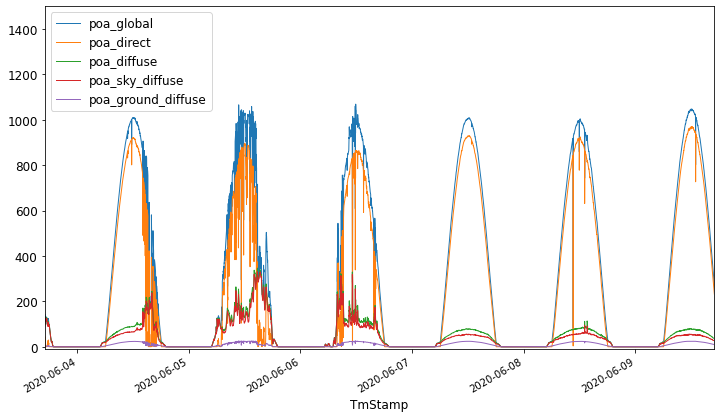

In [7]:
#Calculate Plane of Array (POA) Irradiance
tilt = 35
surface_azimuth = 180
altitude = 1600
#dni_extra = pvlib.irradiance.get_extra_radiation(newdf.index)
total_irrad = pvlib.irradiance.get_total_irradiance(tilt,surface_azimuth,
        solpos['apparent_zenith'],
        solpos['azimuth'],
        df.Direct_Wm2_Avg, 
        df.Global_Wm2_Avg, 
        df.Diffuse_Wm2_Avg,
        dni_extra,
        model='haydavies')

total_irrad.plot(figsize=(12,7))
plt.xlim('2020-06-04','2020-06-10')
plt.ylim(-10,1500)

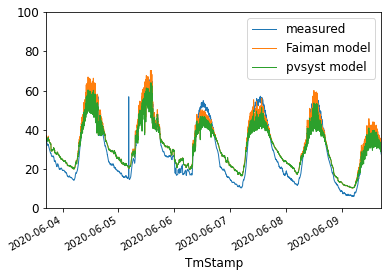

In [8]:
#Calculate Module and Cell Temperature using Faiman Temperature Model
# Model Module temperature
U0 = 24.614 #CFV report
U1 = 7.878 #CFV report
T_faiman = pvlib.temperature.faiman(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg,U0,U1)
T_pvsyst_cell = pvlib.temperature.pvsyst_cell(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg, u_c=U0, u_v=U1, eta_m=0.1, alpha_absorption=0.9)
T_meas = df['PH1_RTD_Avg'].copy()

# Plot measured and modeled temperature
T_meas.plot(label='measured')
T_faiman.plot(label='Faiman model')
T_pvsyst_cell.plot(label='pvsyst model')
plt.xlim('2020-06-04','2020-06-10')
plt.ylim(0,100)
plt.legend(loc='best')

(18417.0, 18423.0)

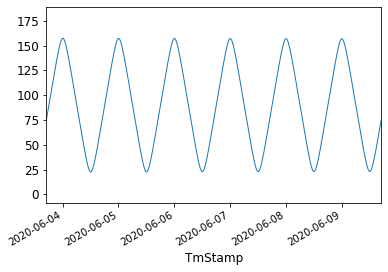

In [9]:
#Calculate angle of incidence (aoi)
aoi = pvlib.irradiance.aoi(tilt, surface_azimuth, solar_zenith=solpos['apparent_zenith'],
        solar_azimuth=solpos['azimuth'])
aoi.plot()
plt.xlim('2020-06-04','2020-06-10')

(18417.0, 18423.0)

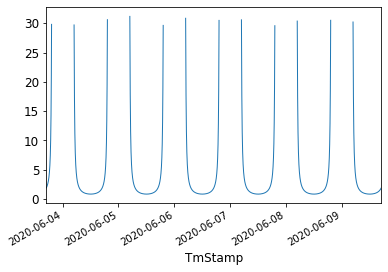

In [10]:
#Calculate absolute airmass
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
am_abs.plot()
plt.xlim('2020-06-04','2020-06-10')

In [11]:
#Define the inverter parameters & create a dataframe for inverter info
inverter = {"Vac":480, "Paco":20000, "Pdco":20400, "Vdcmax":1000 ,"Idcmax":66 , "Mppt_low":380 , "Mppt_high":800, "Pnt":0.075,
           "Pso":2.089, "Vdco":150, "C0":0, "C1":0, "C2":0, "C3":0}

In [12]:
#Model cell and module temperature
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
tcell = pvlib.temperature.sapm_cell(total_irrad['poa_global'],
            df.AmbientTemp_Avg, df.Wind_Speed_Avg,
            **temperature_model_parameters)

In [13]:
#Define Panasonic Module Parameters & create a dataframe for module info
module = {"Vintage":"2016", "Area":"1.67", "Material": "HIT", "Cells_in_Series":96, "Parallel_Strings":1, "Isco":5.87, 
          "Voco":69.67, "Impo":5.48, "Vmpo":57.72, "Aisc":0.000711, "Aimp":0.0003836, "C0":0.994695, "C1":0.005305,
          "Bvoco":-0.171865, "Mbvoc":0, "Bvmpo":-0.1689897, "Mbvmp":0, "N":0.97, "C2":-0.15253, "C3":-15.838,
          "A0":0.95159011, "A1":0.035565004, "A2":-0.001762823, "A3":-0.00033466, "A4":0.00003125,  "A":-3.40567, "B":-0.11234,
         "B5":-2.33454E-09, "B4":3.76061E-07, "B3":-2.16746E-05, "B2":0.000497174, "B1":-0.003944734, "B0":1, "FD":1,
         "IXO":0, "IXXO":0, "C4":0, "C5":0, "C6":0, "C7":0}

In [14]:
cfv = {"I_L_ref":5.927, "I_o_ref":2.1374E-12, "R_sh_ref":1144 , "R_s":0.6, "cells_in_series":96, "gamma_ref":0.95,
        "mu_gamma":-0.0001, "R_sh_0":3850, "alpha_sc": 0.00181, "a_ref":2.429831, "Adjust":0.060475}

In [15]:
#SAM Model for Panasonic System
#Create the datetime index for SAM df
date_rng = pd.date_range(start='3/1/2020', end='3/1/2021', freq='H')
date_rng = date_rng.drop(pd.Timestamp('2021-03-01 00:00:00'))
#Import SAM data and assign the new index to it
results = pd.read_csv('results.csv')
results.index = date_rng
results.index = results.index.tz_localize('MST')

In [16]:
#Add Measured Values to Dataframe
apan_string_p = df['PH4_V_Avg']*df['PH4_I_Avg']
apanh = apan_string_p.resample('H').mean()
results['Measured'] = apanh.to_frame()

In [17]:
#SAPM Model for Panasonic System
pan_effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
pan_dc = pvlib.pvsystem.sapm(pan_effective_irradiance, tcell, module)
pan_ac = pvlib.inverter.sandia(pan_dc['v_mp'], pan_dc['p_mp'], inverter)
#Account for 4 strings of 12 Panasonic modules
#Modeled Panasonic String Voltage and Power
mpan_string_v = pan_dc['v_mp']*12
mpan_string_p = pan_dc['i_mp']*mpan_string_v
mpanh = mpan_string_p.resample('H').mean()
results['SAPM'] = mpanh.to_frame()

In [18]:
#PVWatts DC Power Model for Panasonic System
pan_pvwatts = pvlib.pvsystem.pvwatts_dc(g_poa_effective= df['BroadbandPOA_Avg'], temp_cell=df['PH2_RTD_Avg'], 
                          pdc0=325, gamma_pdc=-0.0029, temp_ref=25.0)
pan_pvwatts = pan_pvwatts*12
panh_pvwatts = pan_pvwatts.resample('H').mean()
results['PVWatts'] = panh_pvwatts

In [19]:
#CEC Single Diode Module Model for Panasonic System
pan_cec_param = pvlib.pvsystem.calcparams_cec( df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], cfv['alpha_sc'], cfv['a_ref'], 
                                              cfv['I_L_ref'], cfv['I_o_ref'], cfv['R_sh_ref'], cfv['R_s'], cfv['Adjust'], 
                                             cfv['cells_in_series'])
pan_cec = pvlib.pvsystem.singlediode(photocurrent = pan_cec_param[0], saturation_current = pan_cec_param[1], resistance_series =
                           pan_cec_param[2], resistance_shunt = pan_cec_param[3], nNsVth = pan_cec_param[4])

pan_cec_pmp = pan_cec['p_mp']*12
pan_cec_pmp = pan_cec_pmp.resample('H').mean()
results['CEC'] = pan_cec_pmp

In [20]:
#Desoto Single Diode Model for Panasonic System
pan_ds_param = pvlib.pvsystem.calcparams_desoto(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], cfv['alpha_sc'], cfv['a_ref'], 
                                        cfv['I_L_ref'], cfv['I_o_ref'], cfv['R_sh_ref'], cfv['R_s'])
pan_ds = pvlib.pvsystem.singlediode(photocurrent = pan_ds_param[0], saturation_current = pan_ds_param[1], resistance_series =
                           pan_ds_param[2], resistance_shunt = pan_ds_param[3], nNsVth = pan_ds_param[4])
pan_ds_pmp = pan_ds['p_mp']*12
pan_ds_pmp = pan_ds_pmp.resample('H').mean()
results['Desoto'] = pan_ds_pmp

In [21]:
#PVSyst Single Diode Model for Panasonic System
#NEED mu_gamma AND R_sh_0 values,not in CECMod, SAM Database, don't match PVPMC
#Found mu gamma and R_sh_0 in pan file on pvpmc cfv
#449.091248
pan_pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], cfv['alpha_sc'], cfv['gamma_ref'],
                                            cfv['mu_gamma'], cfv['I_L_ref'], cfv['I_o_ref'], cfv['R_sh_ref'], cfv['R_sh_0'], 
                                            cfv['R_s'],  cfv['cells_in_series'])
#NEED MU GAMMA AND R_SH_0 VALUES, NOT IN CECMOD, SAM, 
pan_pvs = pvlib.pvsystem.singlediode(photocurrent = pan_pvs_param[0], saturation_current = pan_pvs_param[1], resistance_series =
                           pan_pvs_param[2], resistance_shunt = pan_pvs_param[3], nNsVth = pan_pvs_param[4])

pan_pvs_pmp = pan_pvs['p_mp']*12
pan_pvs_pmp = pan_pvs_pmp.resample('H').mean()
results['PVSyst'] = pan_pvs_pmp


In [22]:
#pvlib.pvsystem.retrieve_sam('CECMod')

Text(0, 0.5, 'Power (W)')

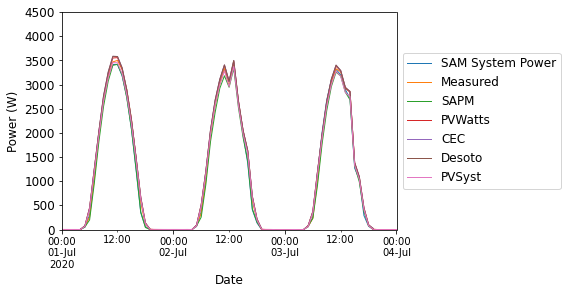

In [23]:
#Plot SAM, Measured, PVWatts, and SAPM values 
results.plot()
plt.xlim('2020-07-01', '2020-07-04')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')

Text(0, 0.5, 'Ratio of Measured to Modeled Power')

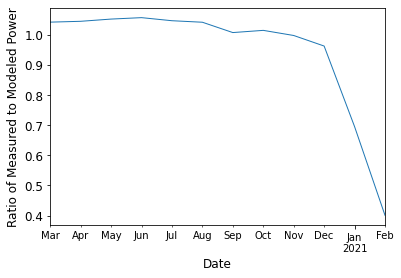

In [24]:
#Resample the data to get the sum of all power produced in a month
#Monthly Modeled Panasonic String Power
mmpan_string_p = mpan_string_p.resample('M').sum()
#Monthly Actual Panasonic String Power
mapan_string_p = apan_string_p.resample('M').sum()

#Plot the modeled power against the actual power
#pan_monthly_string_p.plot(label = 'Modeled')
#pan_actual_monthly.plot(label = 'Actual')
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.xlabel('Date')
#plt.ylabel('Voltage')

#Plot the ratio of measured power to modeled power
ratio = (mapan_string_p/mmpan_string_p)
ratio.plot()
plt.xlabel('Date')
plt.ylabel('Ratio of Measured to Modeled Power')

In [25]:
mae = ((np.subtract(results['Measured'], results['SAPM'])).sum()/len(results['Measured']))/np.mean(results['Measured'])
mae

-0.053683923168186605

In [26]:
#Define functions to calculate Normalized Mean Bias Error and Normalized Root Mean Square Error

def mbe(measured, modeled):
    value = np.mean(np.subtract(modeled,measured))/np.mean(measured)
    return value

def rmse(measured, modeled):
    value = (math.sqrt(np.square(np.subtract(measured, modeled)).mean()))/np.mean(measured)
    return value

def mae(measured, modeled):
    value = ((np.subtract(modeled, measured)).sum()/len(measured))/np.mean(measured)
    return value

In [27]:
#normalize error to remove units
#mean absolute error columns

In [28]:
#Create a dataframe of error values for each model
error_values = {'Model':  ['SAPM', 'SAM', 'PVWatts', 'CEC', 'Desoto'],
        'NMBE': [mbe(results['Measured'], results['SAPM']), 
                mbe(results['Measured'], results['SAM System Power']),
                mbe(results['Measured'], results['PVWatts']),
                mbe(results['Measured'], results['CEC']),
                mbe(results['Measured'], results['Desoto'])],
         'NRMSE' : [rmse(results['Measured'], results['SAPM']),
                   rmse(results['Measured'], results['SAM System Power']), 
                   rmse(results['Measured'], results['PVWatts']), 
                   rmse(results['Measured'], results['CEC']), 
                  rmse(results['Measured'], results['Desoto'])],
        'NMAE' : [mae(results['Measured'], results['SAPM']), 
                mae(results['Measured'], results['SAM System Power']),
                mae(results['Measured'], results['PVWatts']),
                mae(results['Measured'], results['CEC']),
                mae(results['Measured'], results['Desoto'])]
        
        }

error_values = pd.DataFrame(error_values, columns = ['Model', 'NMBE', 'NRMSE', 'NMAE' ])
error_values

,Model,NMBE,NRMSE,NMAE
0,SAPM,0.099360,0.782666,0.053684
1,SAM,0.009223,0.461299,0.009181
2,PVWatts,0.004142,0.435421,0.004123
3,CEC,0.033659,0.564630,0.020153
4,Desoto,0.033664,0.564629,0.020156


(-4500.0, 1500.0)

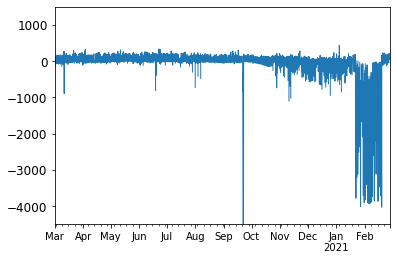

In [29]:
#Plots the difference between SAM & Measured power to detect large differences which could indicate erroneous data
difference = results['Measured'] - results['SAPM']
#difference = apanh - mpanh
difference.plot()
plt.xlim('2020-03-01', '2021-02-28')
plt.ylim(-4500,1500)

(0.0, 5000.0)

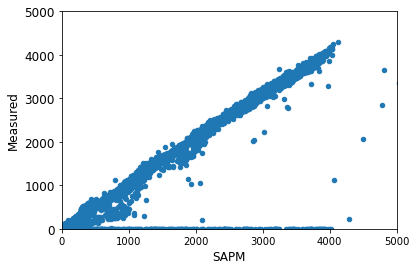

In [30]:
#Plot modeled vs measured power to see the linearity 
results.plot.scatter('SAPM','Measured')
plt.xlim(0, 5000)
plt.ylim(0, 5000)

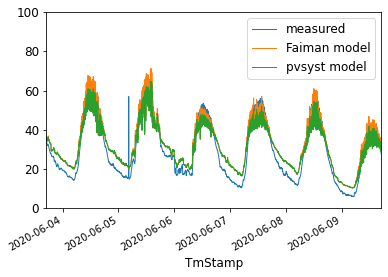

In [31]:
#Calculate Module and Cell Temperature using Faiman Temperature Model
# Model Module temperature
U0 = 24.229 #CFV report
U1 = 7.182 #CFV report
T_faiman = pvlib.temperature.faiman(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg,U0,U1)
T_pvsyst_cell = pvlib.temperature.pvsyst_cell(
    df.BroadbandPOA_Avg, df.AmbientTemp_Avg, df.Wind_Speed_Avg, u_c=U0, u_v=U1, eta_m=0.1, alpha_absorption=0.9)
T_meas = df['LM1_RTD_Avg'].copy()

# Plot measured and modeled temperature
T_meas.plot(label='measured')
T_faiman.plot(label='Faiman model')
T_pvsyst_cell.plot(label='pvsyst model')
plt.xlim('2020-06-04','2020-06-10')
plt.ylim(0,100)
plt.legend(loc='best')

In [32]:
#Define LG Module Parameters & create a dataframe for module info
module = {"Vintage":"2017", "Area":"1.71", "Material": "c-Si", "Cells_in_Series":60, "Parallel_Strings":1, "Isco":10.15, 
          "Voco":39.94, "Impo":9.64, "Vmpo":32.48, "Aisc":0.000706, "Aimp":0.0003228, "C0":1.014279, "C1":-0.01428,
          "Bvoco":-0.111204, "Mbvoc":0, "Bvmpo":-0.1185716, "Mbvmp":0, "N":0.96, "C2":-0.40033, "C3":-14.7721,
          "A0":0.967748, "A1":0.023426, "A2":-0.0008, "A3":-0.00037, "A4":0.00003219, "A":-3.57414, "B":-0.1184, 
         "B5":-1.49207E-09, "B4":2.33152E-07, "B3":-1.35142E-05, "B2":0.000313806, "B1":-0.00248674, "B0":1, "FD":1,
         "IXO":0, "IXXO":0, "C4":0, "C5":0, "C6":0, "C7":0}

In [33]:
cfv = {"I_L_ref":10.350, "I_o_ref":1.0086E-11, "R_sh_ref":334 , "R_s":0.273, "cells_in_series":60, "gamma_ref":0.995,
        "mu_gamma":-0.0005, "R_sh_0":1564, "alpha_sc": 0.002, "a_ref":1.476693, "Adjust":4.687228}

In [34]:
#Generate a DateTime Index for the SAM data
date_rng = pd.date_range(start='3/1/2020', end='3/1/2021', freq='H')
date_rng = date_rng.drop(pd.Timestamp('2021-03-01 00:00:00'))
#Import SAM data and assign the new index to it
lgresults = pd.read_csv('lgresults_new.csv')
lgresults.index = date_rng
lgresults.index = lgresults.index.tz_localize('MST')

In [35]:
#try tunning pvlib sam 

In [36]:
#SAPM Model for LG System
lg_effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
            total_irrad['poa_direct'], total_irrad['poa_diffuse'],
            am_abs, aoi, module)
lg_dc = pvlib.pvsystem.sapm(lg_effective_irradiance, tcell, module)
lg_ac = pvlib.inverter.sandia(lg_dc['v_mp'], lg_dc['p_mp'], inverter)

#Account for 4 strings of 12 LG modules
lg_string_v = lg_dc['v_mp']*12
lg_string_p = lg_dc['i_mp']*lg_string_v
mlgh = lg_string_p.resample('H').mean()
lgresults['SAPM'] = mlgh.to_frame()

In [37]:
#Add Measured Values to results
lg_actual_p = df['LM1_V_Avg']*df['LM1_I_Avg']
algh = lg_actual_p.resample('H').mean()
lgresults['Measured'] = algh.to_frame()

In [38]:
#PVWatts DC Power Model for LG System
lg_pvwatts = pvlib.pvsystem.pvwatts_dc(g_poa_effective= df['BroadbandPOA_Avg'], temp_cell=df['LM2_RTD_Avg'], 
                          pdc0=320, gamma_pdc=-0.00357, temp_ref=25.0)
lg_pvwatts = lg_pvwatts*12
lgh_pvwatts = lg_pvwatts.resample('H').mean()
lgresults['PVWatts'] = lgh_pvwatts

In [39]:
#CEC Single Diode Module Model for LG System
lg_cec_param = pvlib.pvsystem.calcparams_cec(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], cfv['alpha_sc'], cfv['a_ref'], 
                                              cfv['I_L_ref'], cfv['I_o_ref'], cfv['R_sh_ref'], cfv['R_s'], cfv['Adjust'], 
                                             cfv['cells_in_series'])
lg_cec = pvlib.pvsystem.singlediode(photocurrent = lg_cec_param[0], saturation_current = lg_cec_param[1], resistance_series =
                           lg_cec_param[2], resistance_shunt = lg_cec_param[3], nNsVth = lg_cec_param[4])

lg_cec_pmp = lg_cec['p_mp']*12
lg_cec_pmp = lg_cec_pmp.resample('H').mean()
lgresults['CEC'] = lg_cec_pmp

In [40]:
#Desoto Single Diode Model for LG System
lg_ds_param = pvlib.pvsystem.calcparams_desoto(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], cfv['alpha_sc'], cfv['a_ref'], 
                                        cfv['I_L_ref'], cfv['I_o_ref'], cfv['R_sh_ref'], cfv['R_s'])
lg_ds = pvlib.pvsystem.singlediode(photocurrent = lg_ds_param[0], saturation_current = lg_ds_param[1], resistance_series =
                           lg_ds_param[2], resistance_shunt = lg_ds_param[3], nNsVth = lg_ds_param[4])
lg_ds_pmp = lg_ds['p_mp']*12
lg_ds_pmp = lg_ds_pmp.resample('H').mean()
lgresults['Desoto'] = lg_ds_pmp

In [41]:
#PVSyst Single Diode Model for Panasonic System
#NEED mu_gamma AND R_sh_0 values,not in CECMod, SAM Database, don't match PVPMC

lg_pvs_param = pvlib.pvsystem.calcparams_pvsyst(df['BroadbandPOA_Avg'], df['PH1_RTD_Avg'], cfv['alpha_sc'], cfv['gamma_ref'],
                                            cfv['mu_gamma'], cfv['I_L_ref'], cfv['I_o_ref'], cfv['R_sh_ref'], cfv['R_sh_0'], 
                                            cfv['R_s'],  cfv['cells_in_series'])
#NEED MU GAMMA AND R_SH_0 VALUES, NOT IN CECMOD, SAM, 
lg_pvs = pvlib.pvsystem.singlediode(photocurrent = lg_pvs_param[0], saturation_current = lg_pvs_param[1], resistance_series =
                           lg_pvs_param[2], resistance_shunt = lg_pvs_param[3], nNsVth = lg_pvs_param[4])

lg_pvs_pmp = lg_pvs['p_mp']*12
lg_pvs_pmp = lg_pvs_pmp.resample('H').mean()
lgresults['PVSyst'] = lg_pvs_pmp


Text(0, 0.5, 'Power (W)')

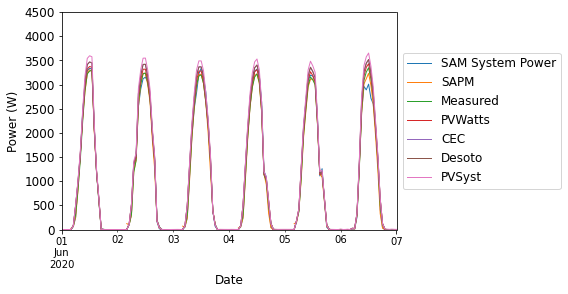

In [42]:
#Plot SAM, Measured, and SAPM values 
lgresults.plot()
plt.xlim('2020-06-01', '2020-06-07')
plt.ylim(0,4500)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Power (W)')

In [43]:
lgerror_values = {'Model':  ['SAPM', 'SAM', 'PVWatts', 'CEC', 'Desoto'],
        'NMBE': [mbe(lgresults['Measured'], lgresults['SAPM']), 
                mbe(lgresults['Measured'], lgresults['SAM System Power']),
                mbe(lgresults['Measured'], lgresults['PVWatts']),
                mbe(lgresults['Measured'], lgresults['CEC']),
                mbe(lgresults['Measured'], lgresults['Desoto'])],
         'NRMSE' : [rmse(lgresults['Measured'], lgresults['SAPM']),
                   rmse(lgresults['Measured'], lgresults['SAM System Power']), 
                   rmse(lgresults['Measured'], lgresults['PVWatts']), 
                   rmse(lgresults['Measured'], lgresults['CEC']), 
                  rmse(lgresults['Measured'], lgresults['Desoto'])],
        'NMAE' : [mae(lgresults['Measured'], lgresults['SAPM']), 
                mae(lgresults['Measured'], lgresults['SAM System Power']),
                mae(lgresults['Measured'], lgresults['PVWatts']),
                mae(lgresults['Measured'], lgresults['CEC']),
                mae(lgresults['Measured'], lgresults['Desoto'])]
        }

lgerror_values = pd.DataFrame(lgerror_values, columns = ['Model', 'NMBE', 'NRMSE', 'NMAE'])
lgerror_values

,Model,NMBE,NRMSE,NMAE
0,SAPM,0.215192,0.911957,0.116268
1,SAM,-0.003211,0.592664,-0.003197
2,PVWatts,0.063058,0.608129,0.062777
3,CEC,0.153042,0.713054,0.091633
4,Desoto,0.153276,0.713088,0.091773


Text(0, 0.5, 'Ratio of Measured to Modeled Power')

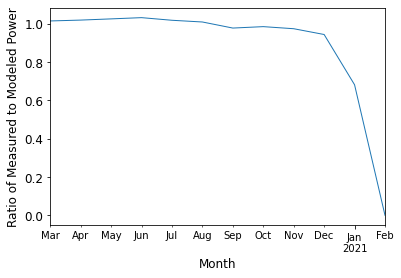

In [44]:
#Resample the data to get the sum of all power produced in a month
lg_model_monthly = lg_string_p.resample('M').sum()
lg_actual_monthly = lg_actual_p.resample('M').sum()

#lg_monthly_string_p.plot(label = 'Modeled')
#lg_actual_monthly.plot(label = 'Actual')
#plt.legend(loc='center left', bbox_to_anchor=(1,0.5))
#plt.xlabel('Date')
#plt.ylabel('Power')

#Plot the ratio of measured power to modeled power
ratio = (lg_actual_monthly/lg_model_monthly)
ratio.plot()
plt.xlabel('Month')
plt.ylabel('Ratio of Measured to Modeled Power')

<AxesSubplot:>

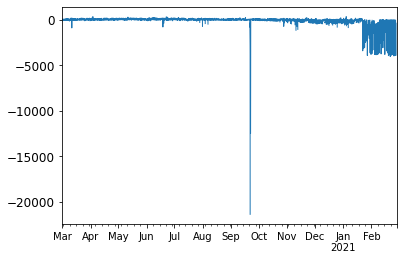

In [45]:
lgdifference = lgresults['Measured'] - lgresults['SAPM']
lgdifference.plot()

<AxesSubplot:xlabel='SAPM', ylabel='Measured'>

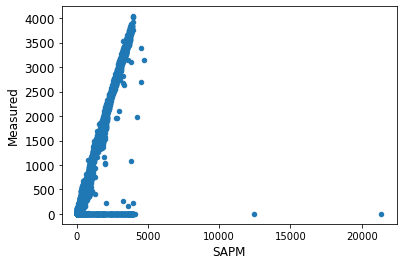

In [46]:
#Plot modeled vs measured power to see the linearity 
lgresults.plot.scatter('SAPM','Measured')

In [47]:
wdf = np.radians(solpos['apparent_zenith'])
wdf = wdf.to_frame()
wdf['GHI'] = df['Global_Wm2_Avg']
wdf['DNI'] = df['Direct_Wm2_Avg']
wdf['DHI'] = df['Diffuse_Wm2_Avg']
wdf['GHI Calc'] = (wdf['DHI']) + ((wdf['DNI'])*np.cos(wdf['apparent_zenith']))
wdf['DNI Calc'] = pvlib.irradiance.dni(wdf['GHI'], wdf['DHI'], solpos['apparent_zenith'])
wdf['DHI Calc'] = (wdf['GHI']) - ((wdf['DNI'])*np.cos(wdf['apparent_zenith']))
wdf['% Error GHI'] = ((wdf['GHI'] - wdf['GHI Calc'])/(wdf['GHI Calc']))*100
wdf['% Error DNI'] = ((wdf['DNI'] - wdf['DNI Calc'])/(wdf['DNI Calc']))*100
wdf['% Error DHI'] = ((wdf['DHI'] - wdf['DHI Calc'])/(wdf['DHI Calc']))*100

(0.0, 1050.0)

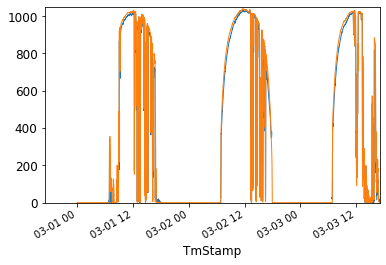

In [48]:
wdf['DNI Calc'].plot()
wdf['DNI'].plot()
plt.xlim('2020-03-01', '2020-03-04')
plt.ylim(0,1050)